In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, MaxPool2D, concatenate, BatchNormalization, Dropout, AveragePooling2D
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model, save_img
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
os.mkdir('train_class')
os.mkdir('val_class')

In [3]:
emo_classes = {'0':'neutral', '1':'happy', '2':'sad', '3':'surprise', '4':'fear', '5':'disgust', '6':'anger', '7':'contempt'}
train_src = "/content/drive/MyDrive/AffectNet/train"
train_dst = "train_class/"
val_src = "/content/drive/MyDrive/AffectNet/val"
val_dst = "val_class/"

In [4]:
for class_no,emotion in emo_classes.items():
    new_train_src = os.path.join(train_src, class_no)
    new_train_dst = os.path.join(train_dst, emotion)
    os.mkdir(f'train_class/{emotion}')
    for img in os.listdir(new_train_src):
        src = os.path.join(new_train_src, img)
        dst = os.path.join(new_train_dst, img)
        img_ = img_to_array(load_img(src, target_size=(224,224)))
        save_img(dst, img_)
    new_val_src = os.path.join(val_src, class_no)
    new_val_dst = os.path.join(val_dst, emotion)
    os.mkdir(f'val_class/{emotion}') 
    for img in os.listdir(new_val_src):
        src = os.path.join(new_val_src, img)
        dst = os.path.join(new_val_dst, img)
        img_ = img_to_array(load_img(src, target_size=(224,224)))
        save_img(dst, img_)

In [5]:
train_paths = {}
val_paths ={}
for class_no,emotion in emo_classes.items():
    new_train_dst = os.path.join(train_dst, emotion)
    new_val_dst = os.path.join(val_dst, emotion)
    train_paths[emotion] = new_train_dst
    val_paths[emotion] = new_val_dst

NEUTRAL


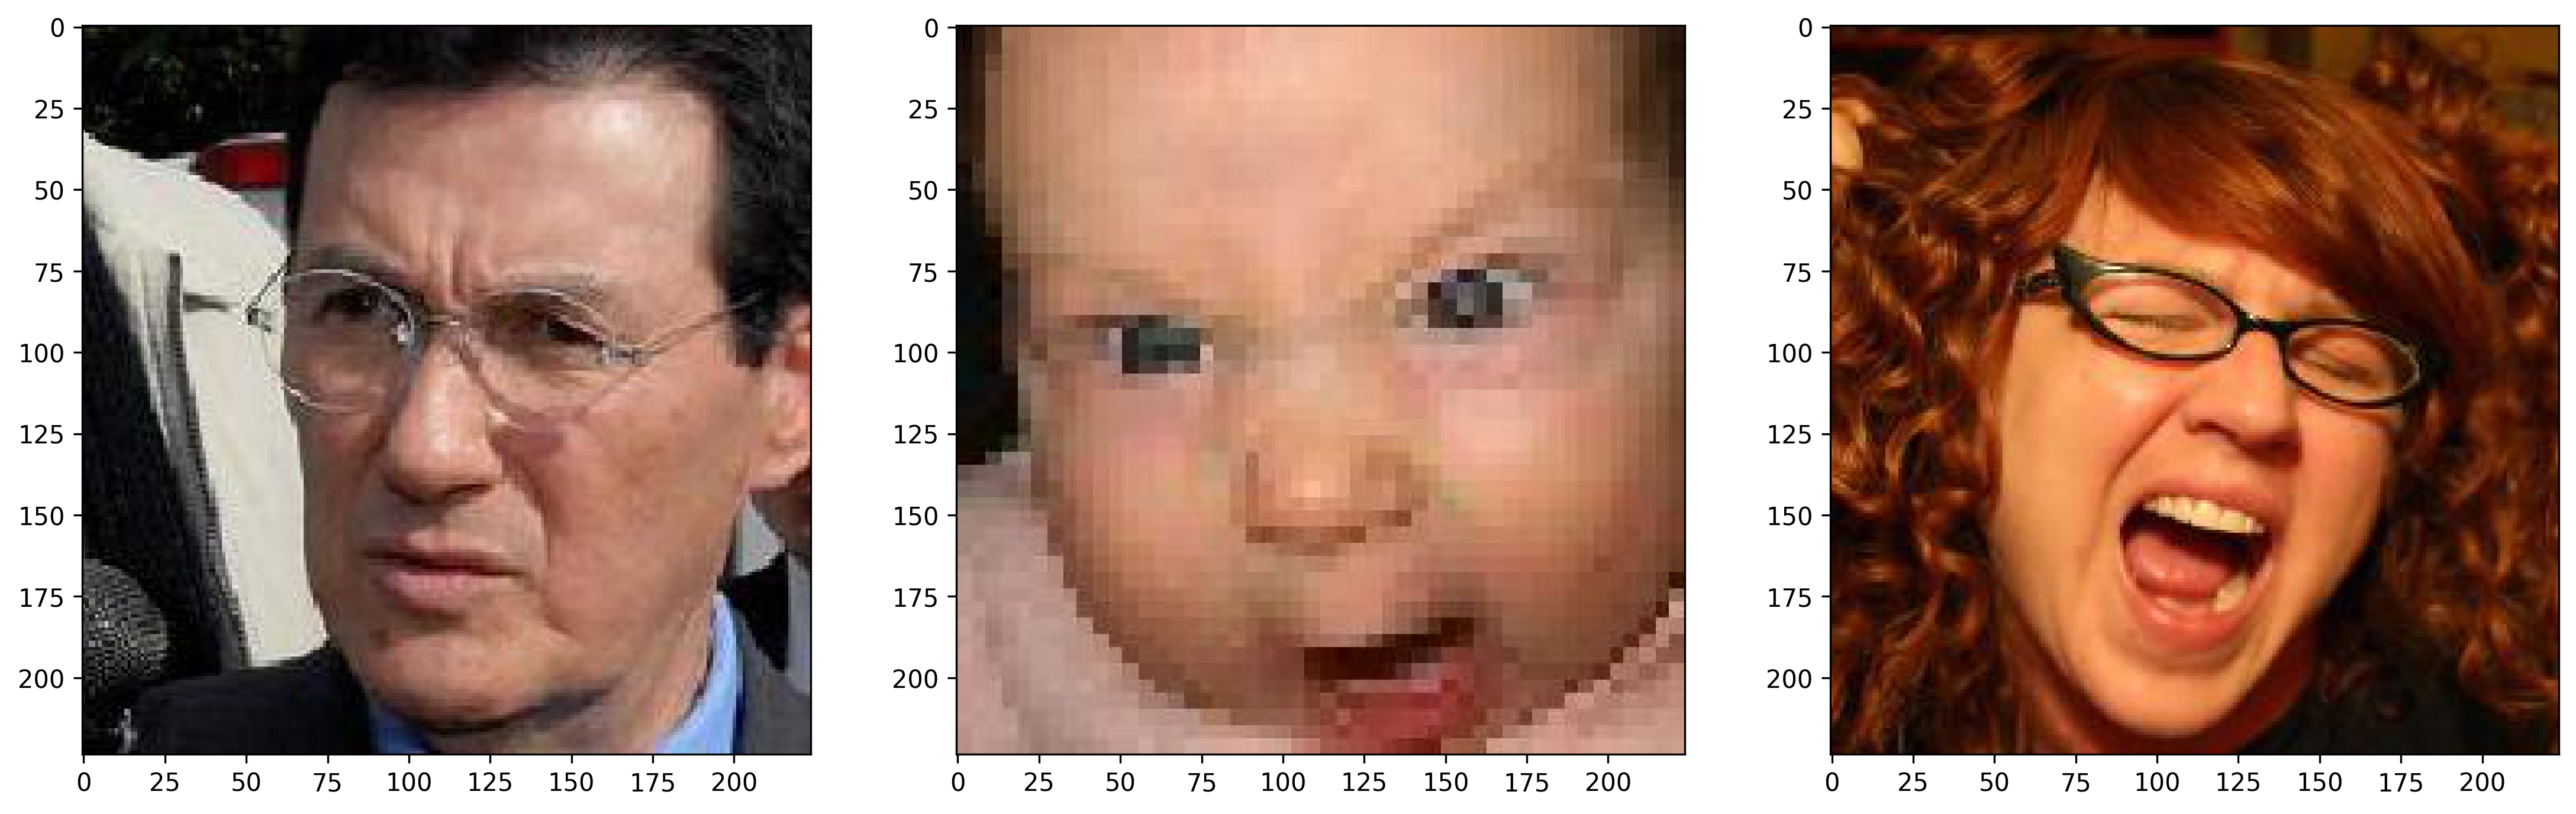

HAPPY


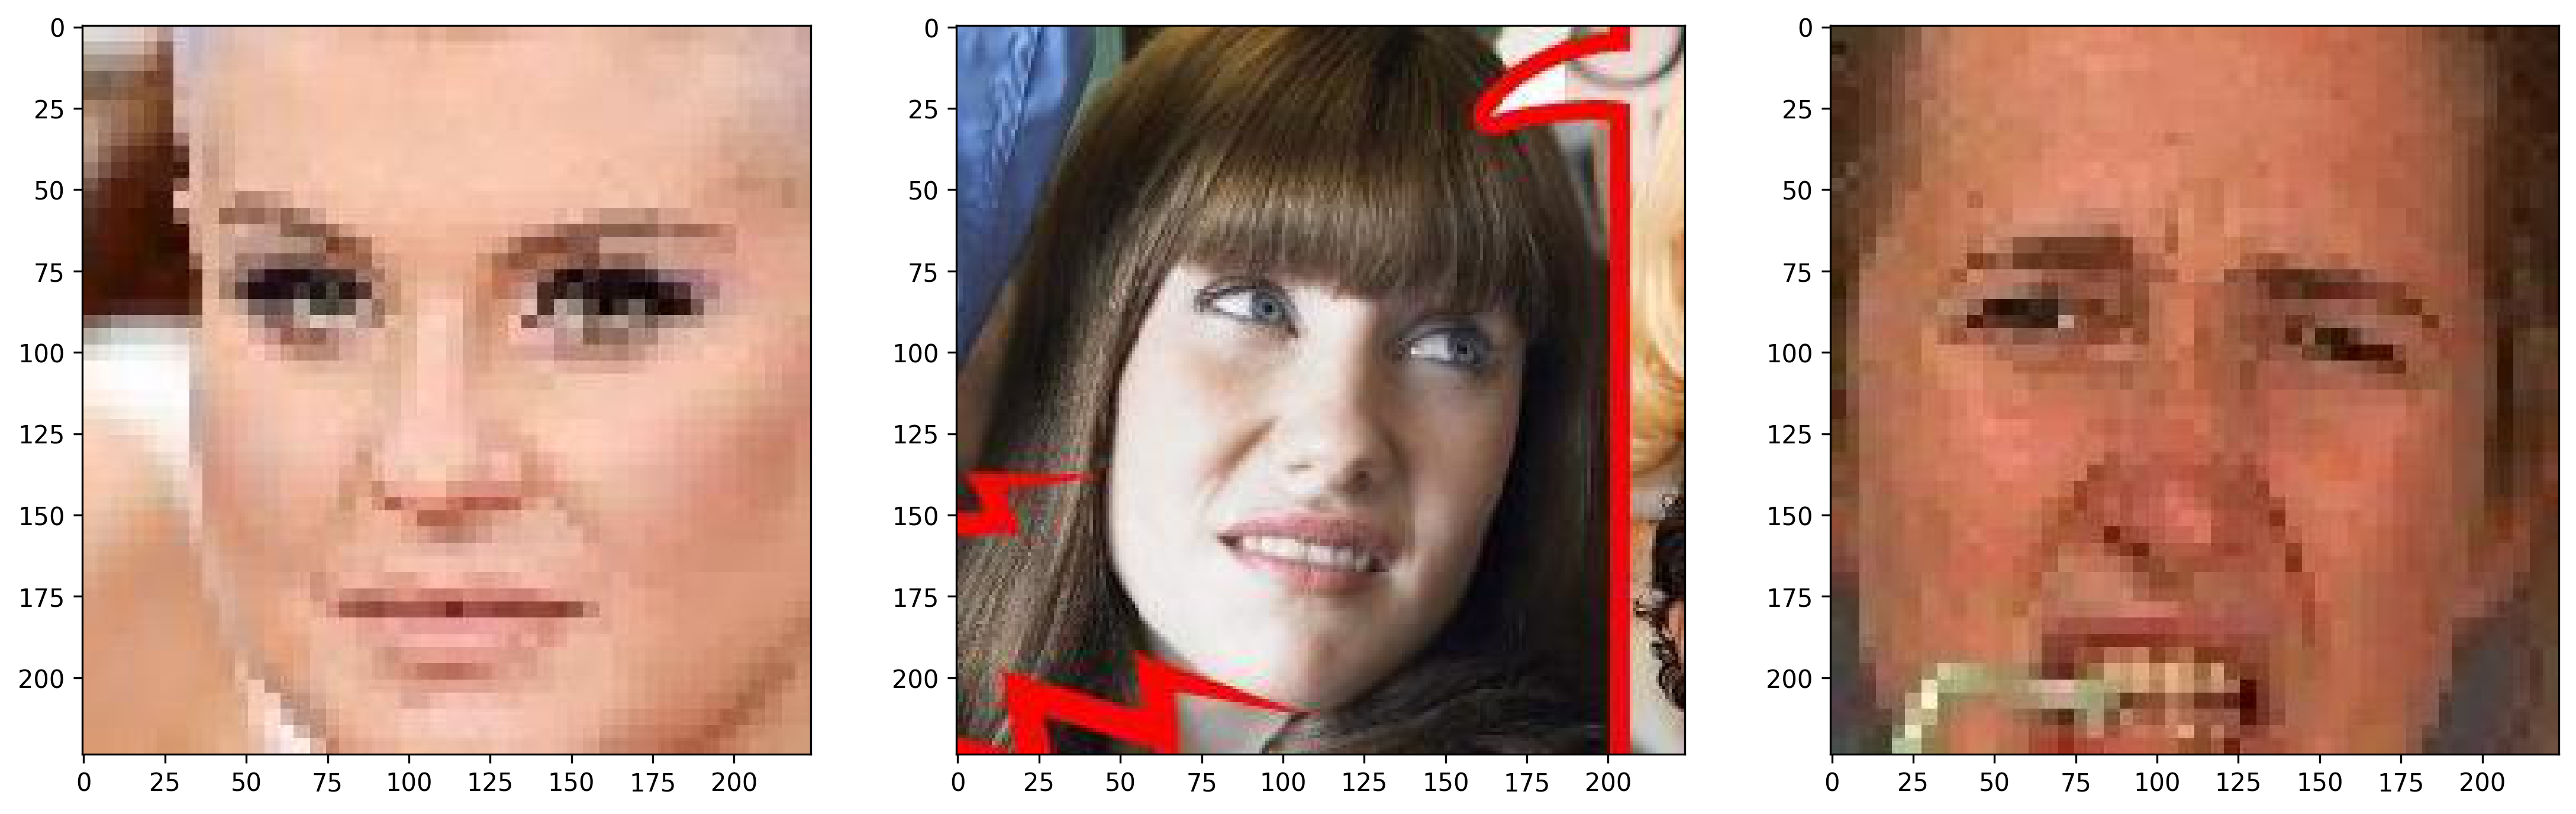

SAD


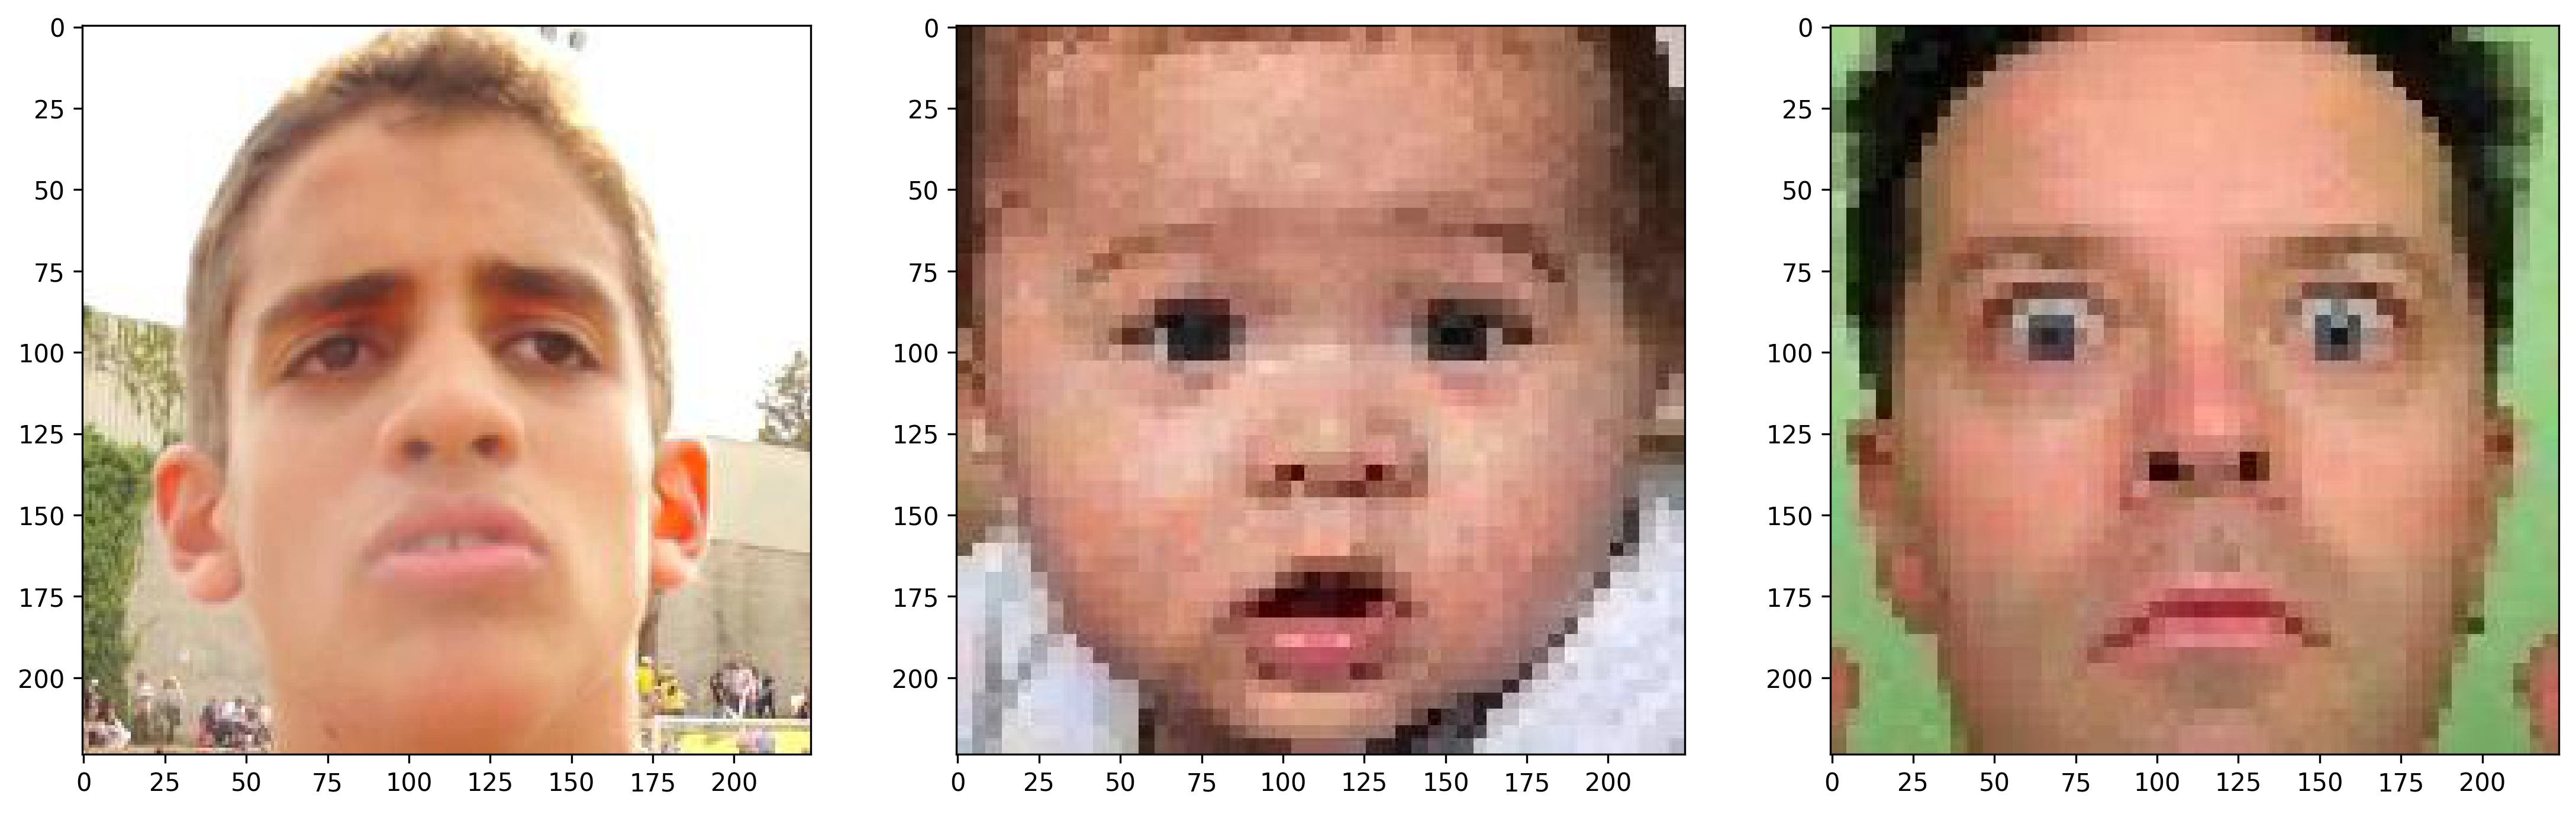

SURPRISE


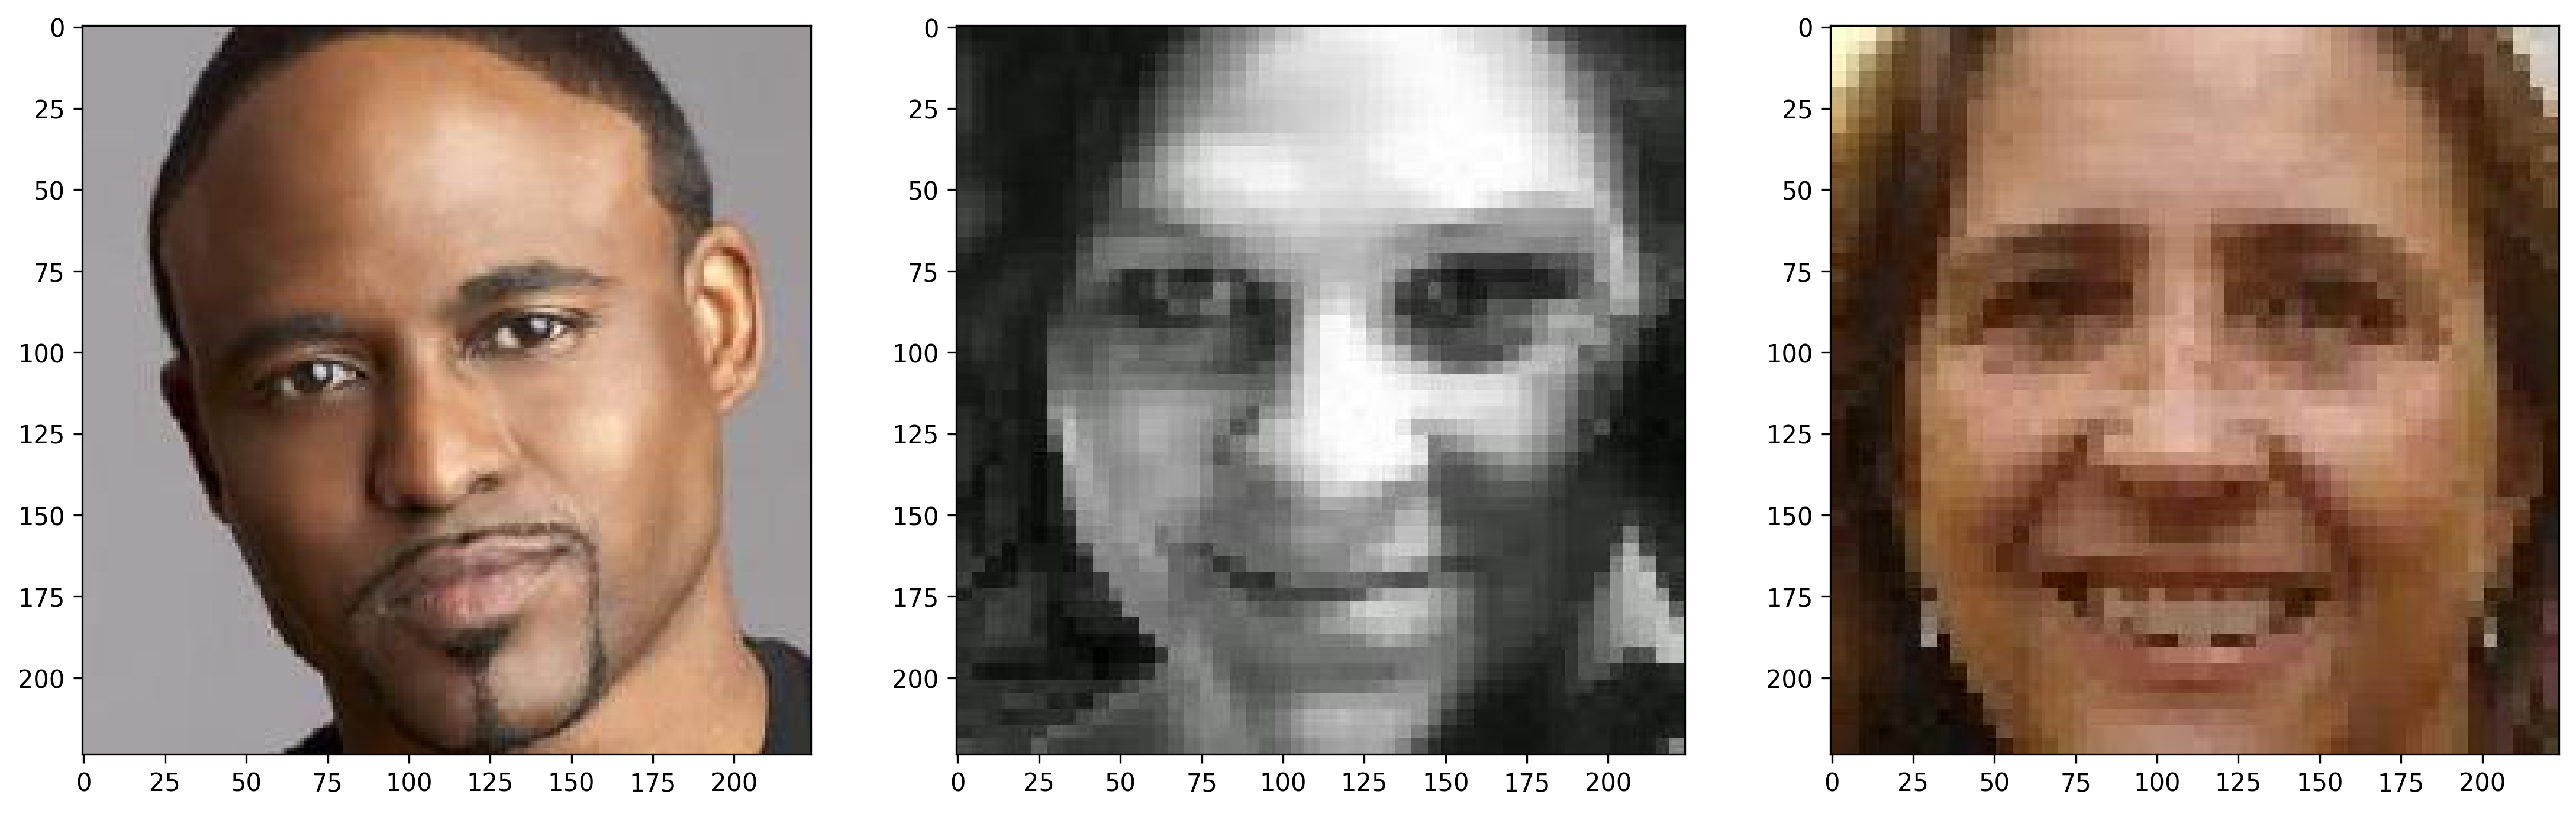

FEAR


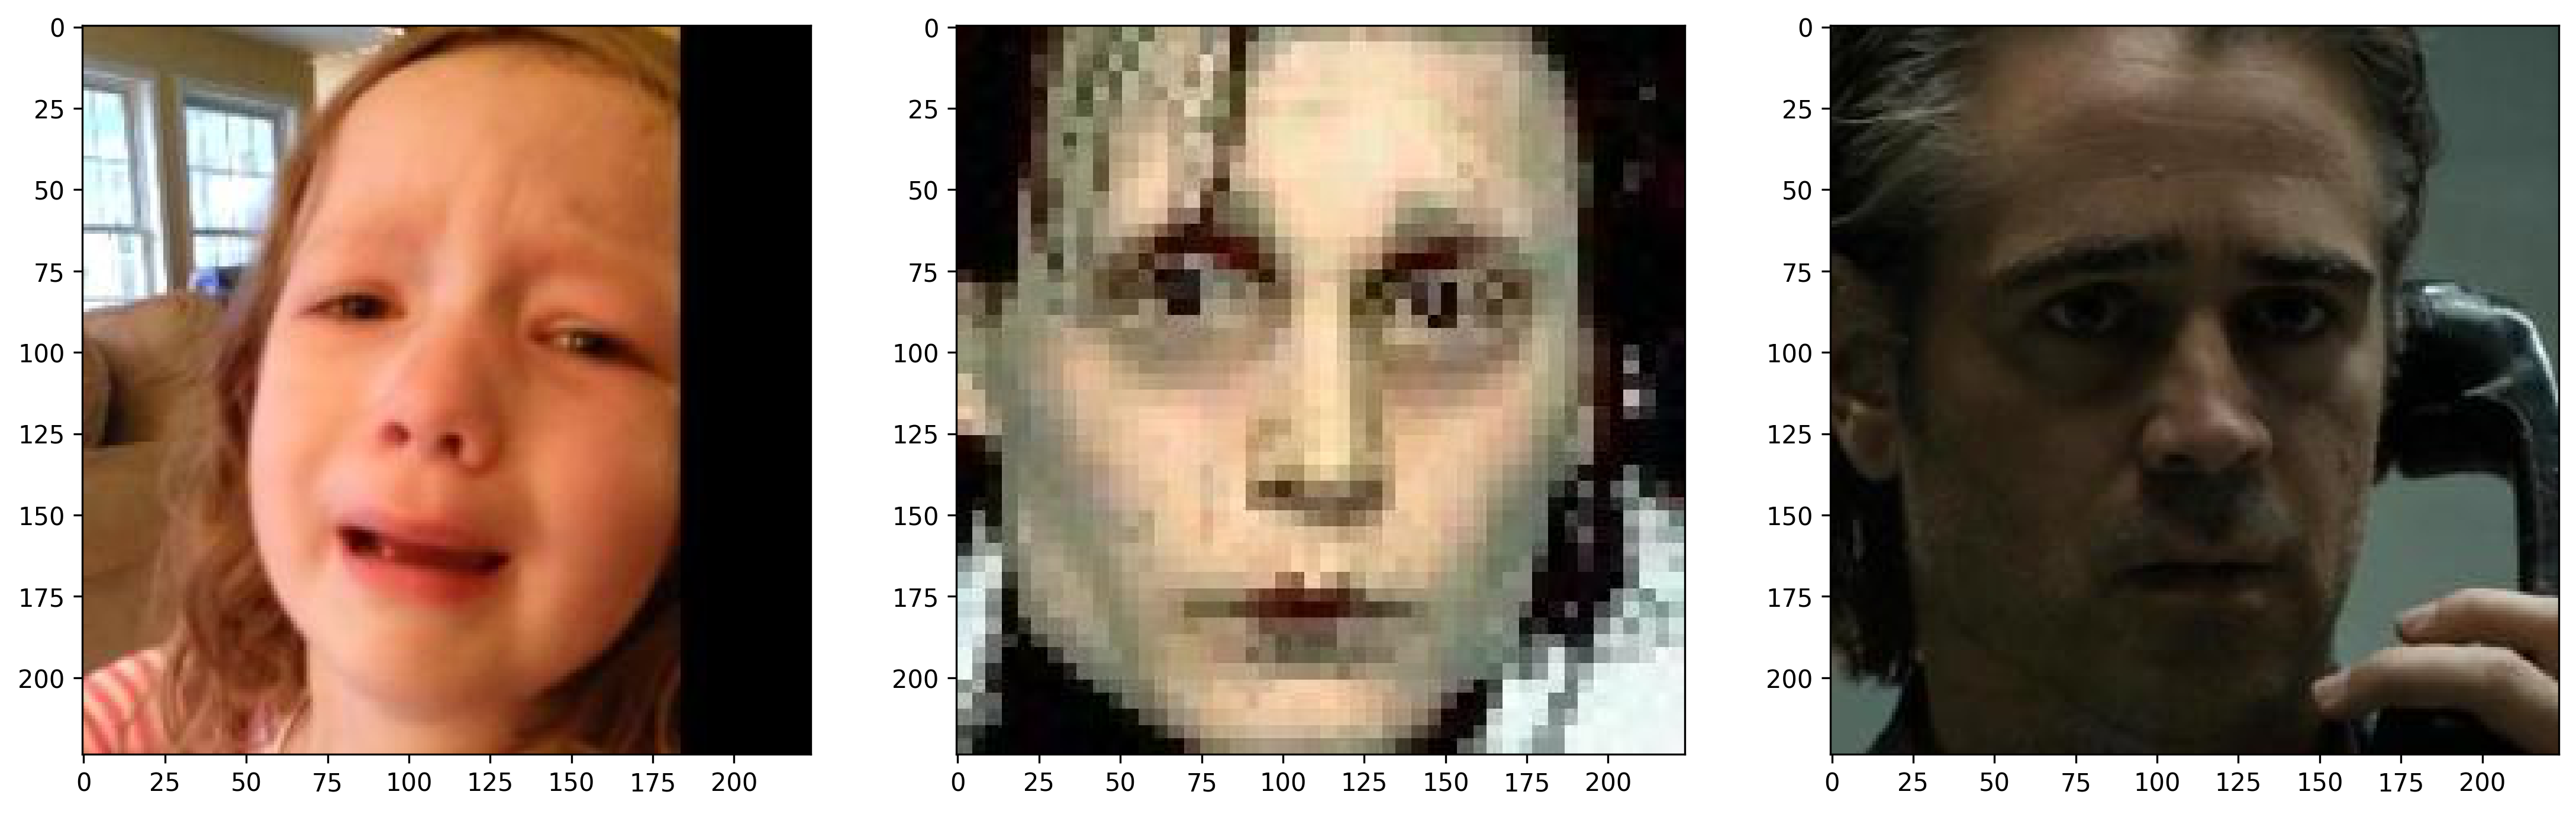

DISGUST


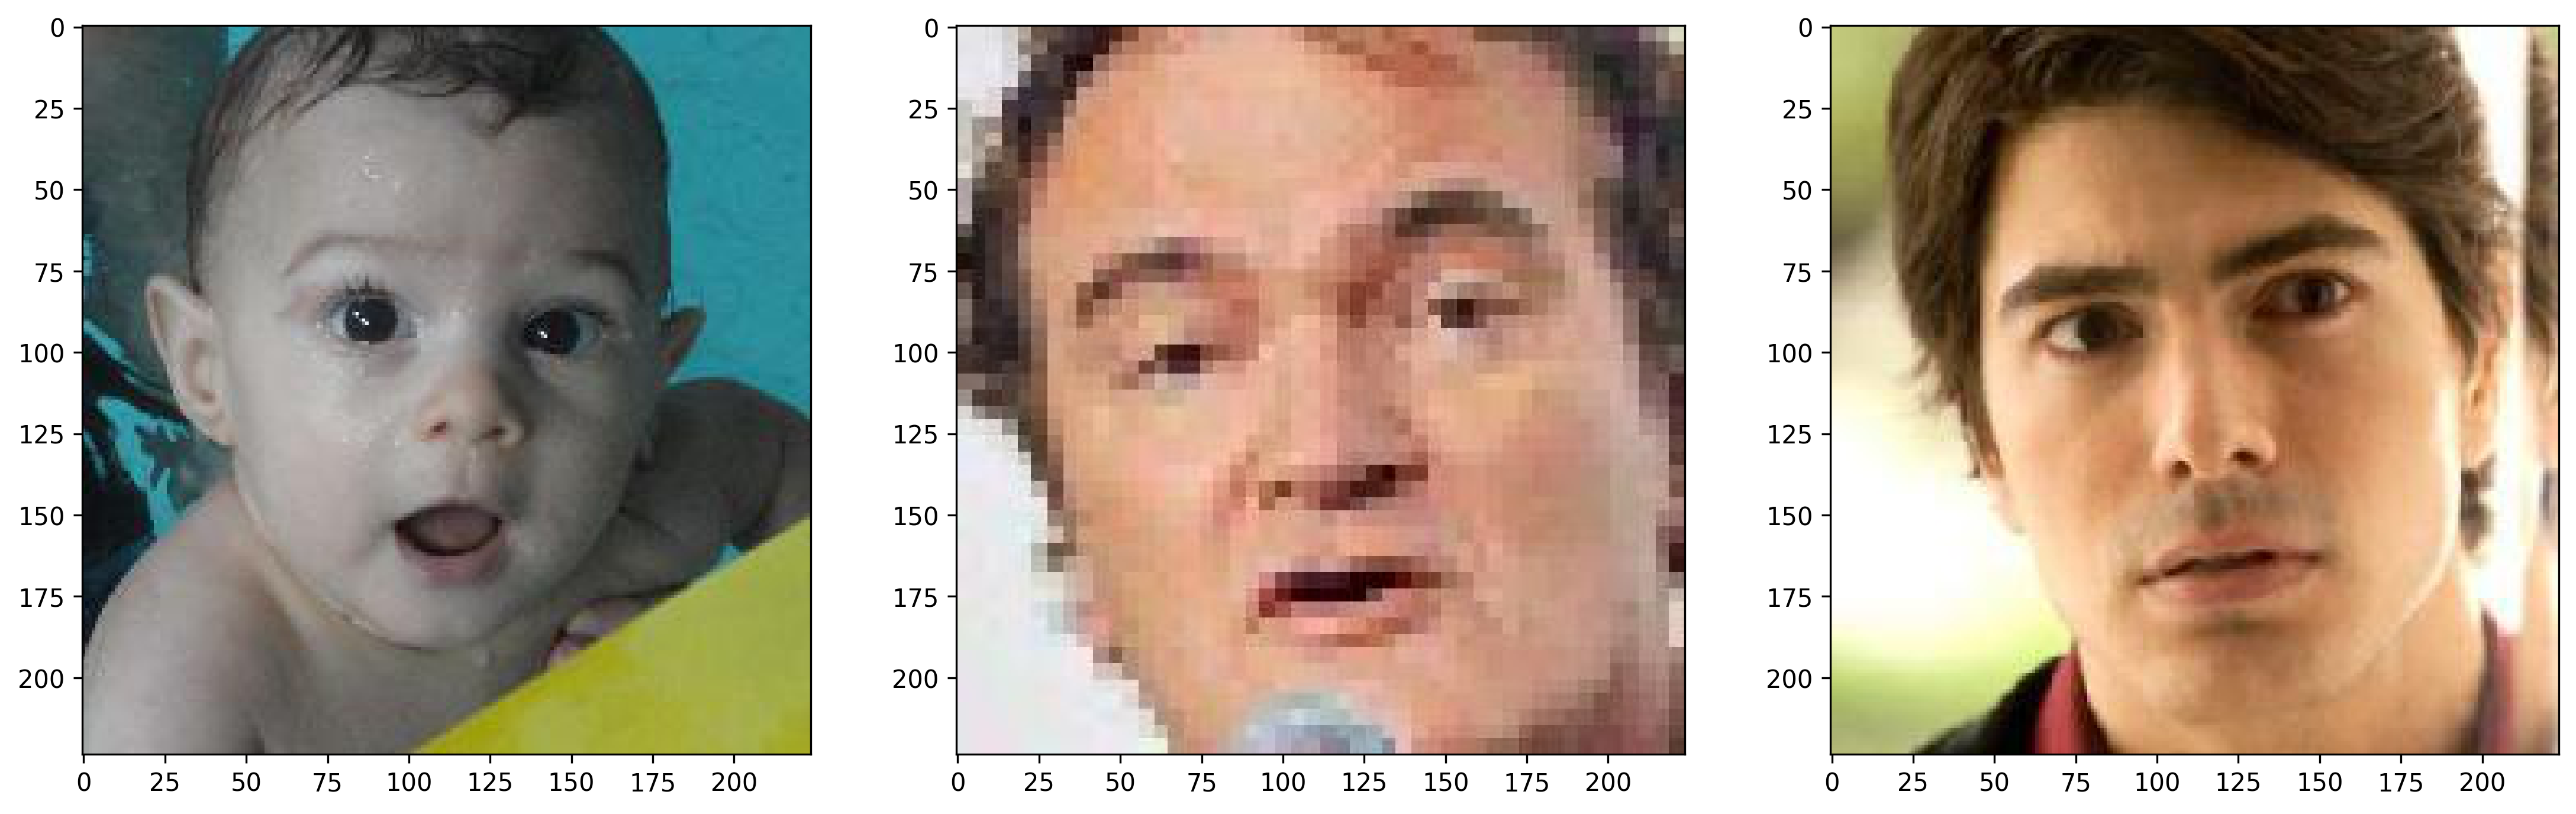

ANGER


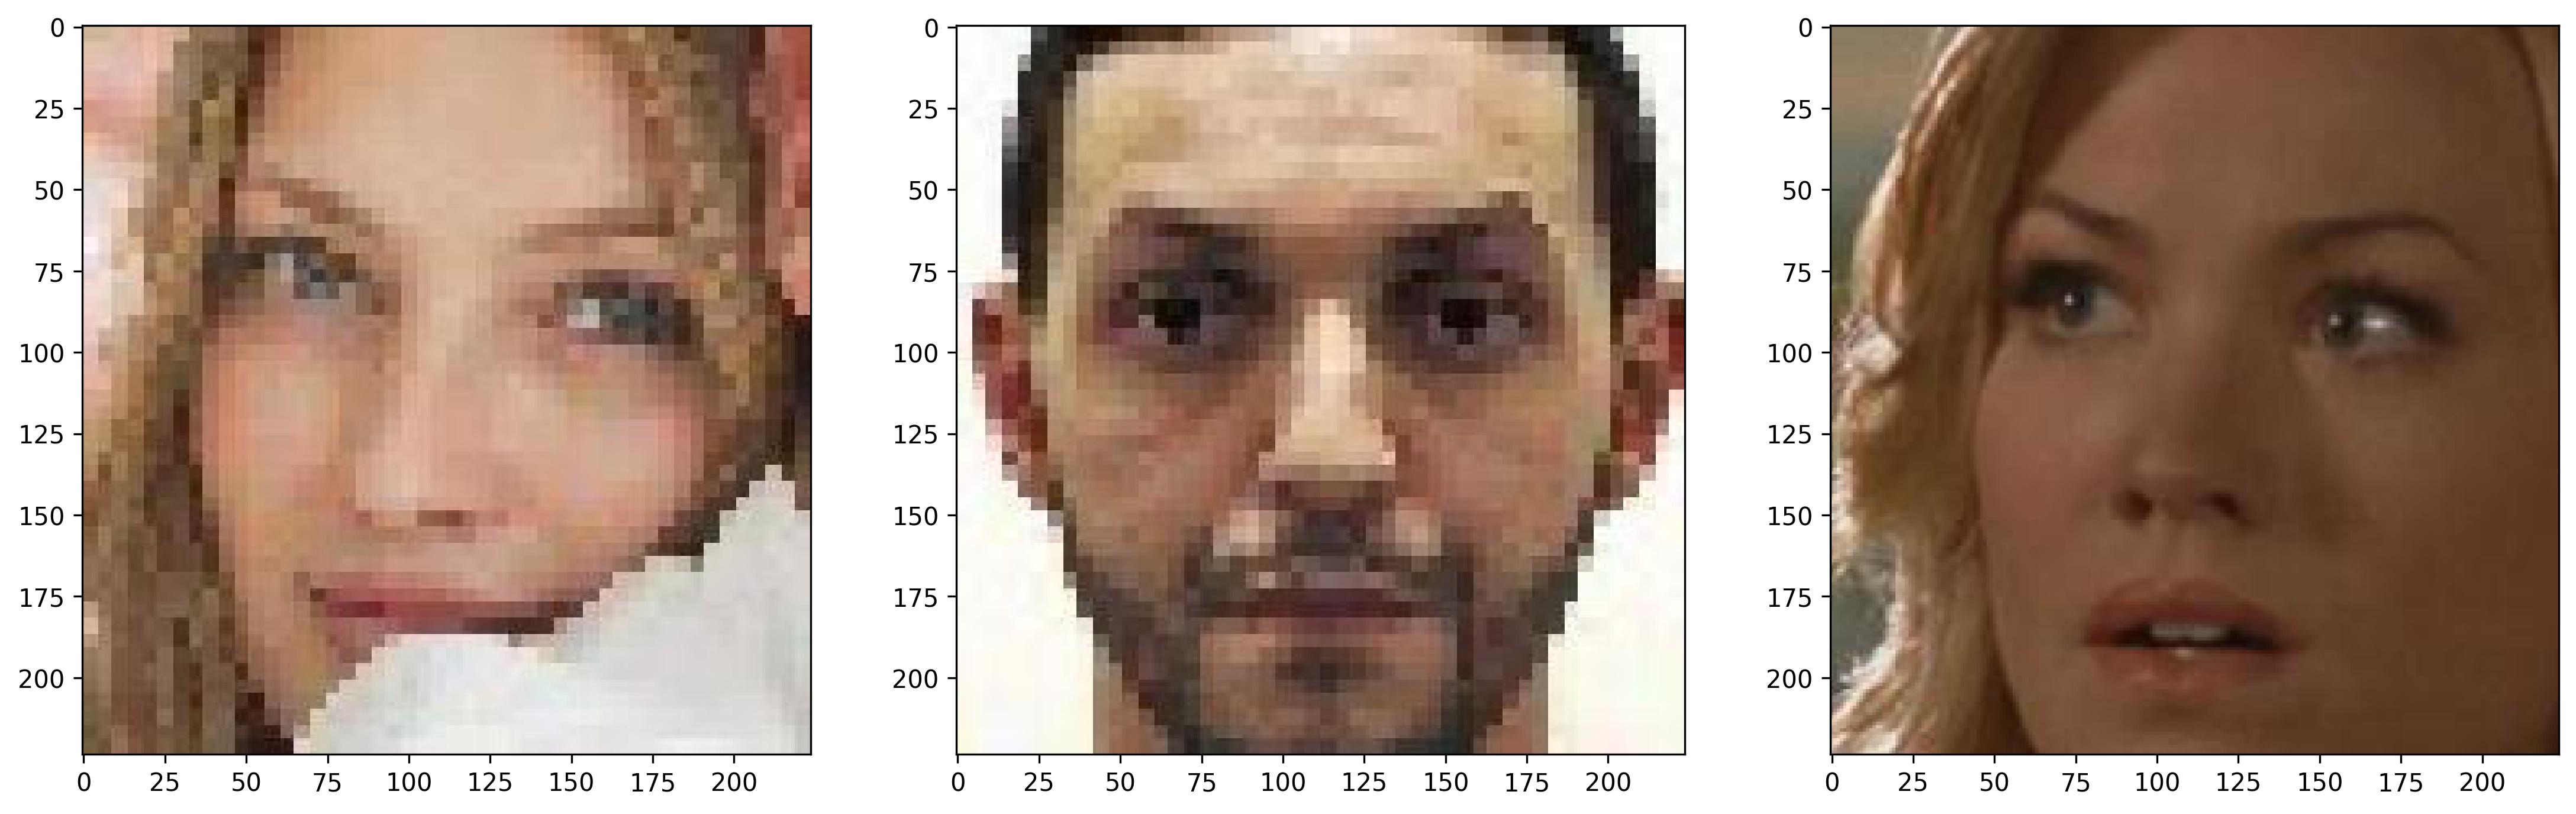

CONTEMPT


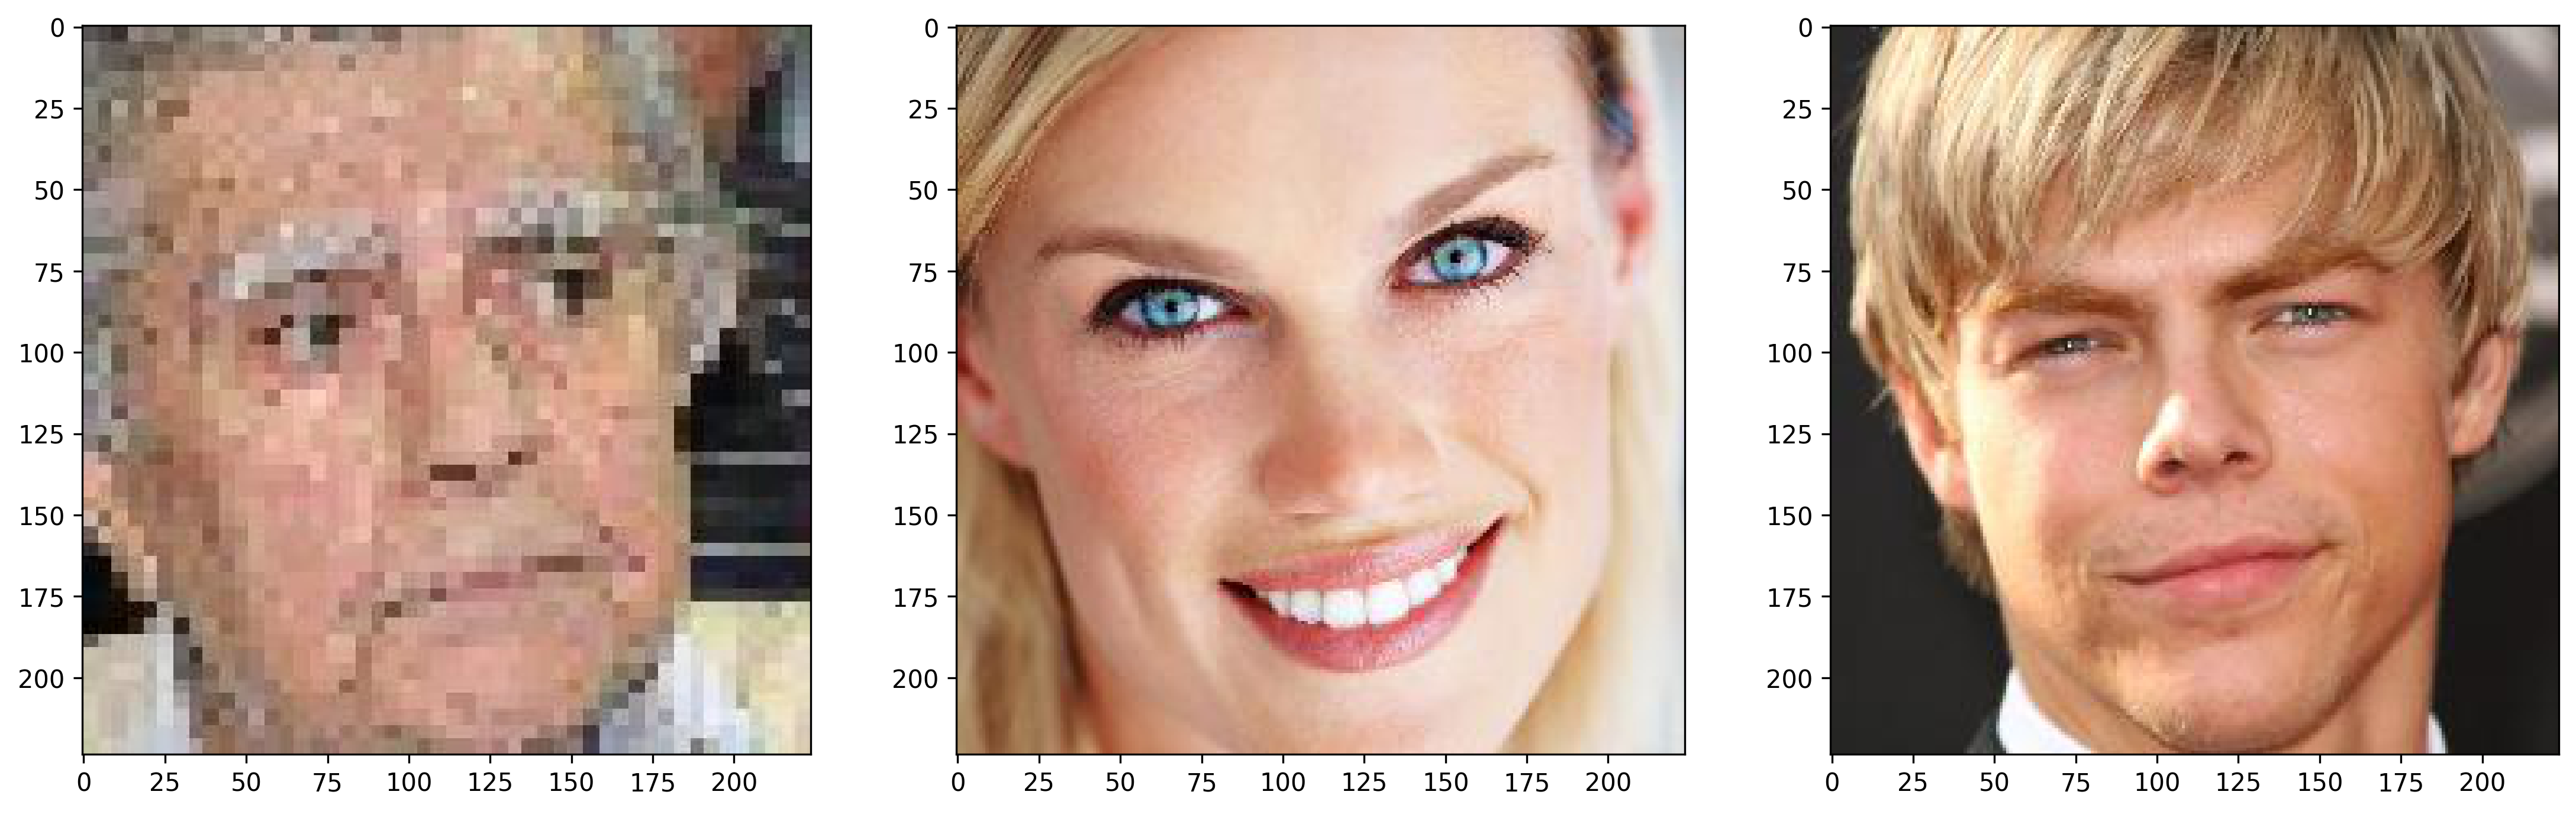

In [6]:
for i in train_paths.keys():
    print(f'{i.upper()}')
    figure_faces, axes = plt.subplots(nrows=1,ncols=3, figsize=[18,6], dpi=300)
    axes = axes.ravel()
    image_list = os.listdir(train_paths.get(i))[:5]
    for j in range(len(axes)):
        axes[j].imshow(load_img(os.path.join(train_paths.get(i), image_list[j])))
    plt.show()

In [14]:
train_genarator = ImageDataGenerator(rescale=1. / 255, rotation_range=15, horizontal_flip=True, validation_split=0.2)
val_genarator = ImageDataGenerator(rescale=1. / 255)
train_data_genarator = train_genarator.flow_from_directory("train_class/", target_size=(224, 224), color_mode='grayscale', batch_size = 328)
val_data_genarator = val_genarator.flow_from_directory("val_class/", target_size=(224, 224), color_mode='grayscale', batch_size = 328)

Found 37553 images belonging to 8 classes.
Found 4000 images belonging to 8 classes.


In [15]:
check_pointer = ModelCheckpoint(filepath='AffectNetModel.h5', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1)

In [16]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    conv_1x1 = Conv2D(filters_1x1, kernel_size=(1, 1), padding='same', activation='relu')(x)
    pre_conv_3x3 = Conv2D(filters_3x3_reduce, kernel_size=(1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, kernel_size=(3, 3), padding='same', activation='relu')(pre_conv_3x3)
    pre_conv_5x5 = Conv2D(filters_5x5_reduce, kernel_size=(1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, kernel_size=(5, 5), padding='same', activation='relu')(pre_conv_5x5)
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    return output

In [17]:
input_layer = Input(shape=(224, 224, 1))
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)
x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32, name='inception_3a')
x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64, name='inception_3b')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)
x = inception_module(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64, name='inception_4a')
x = inception_module(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64, name='inception_4b')
x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64, name='inception_4c')
x = inception_module(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool_proj=64, name='inception_4d')
x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, name='inception_4e')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)
x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, name='inception_5a')
x = inception_module(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128, name='inception_5b')
x = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(x)
x = Flatten()(x)
x = Dense(units=512, activation=relu)(x)
x = Dropout(0.5)(x)
output_layer = Dense(units=8, activation=softmax)(x)
model = Model(input_layer, output_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  3200        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                          

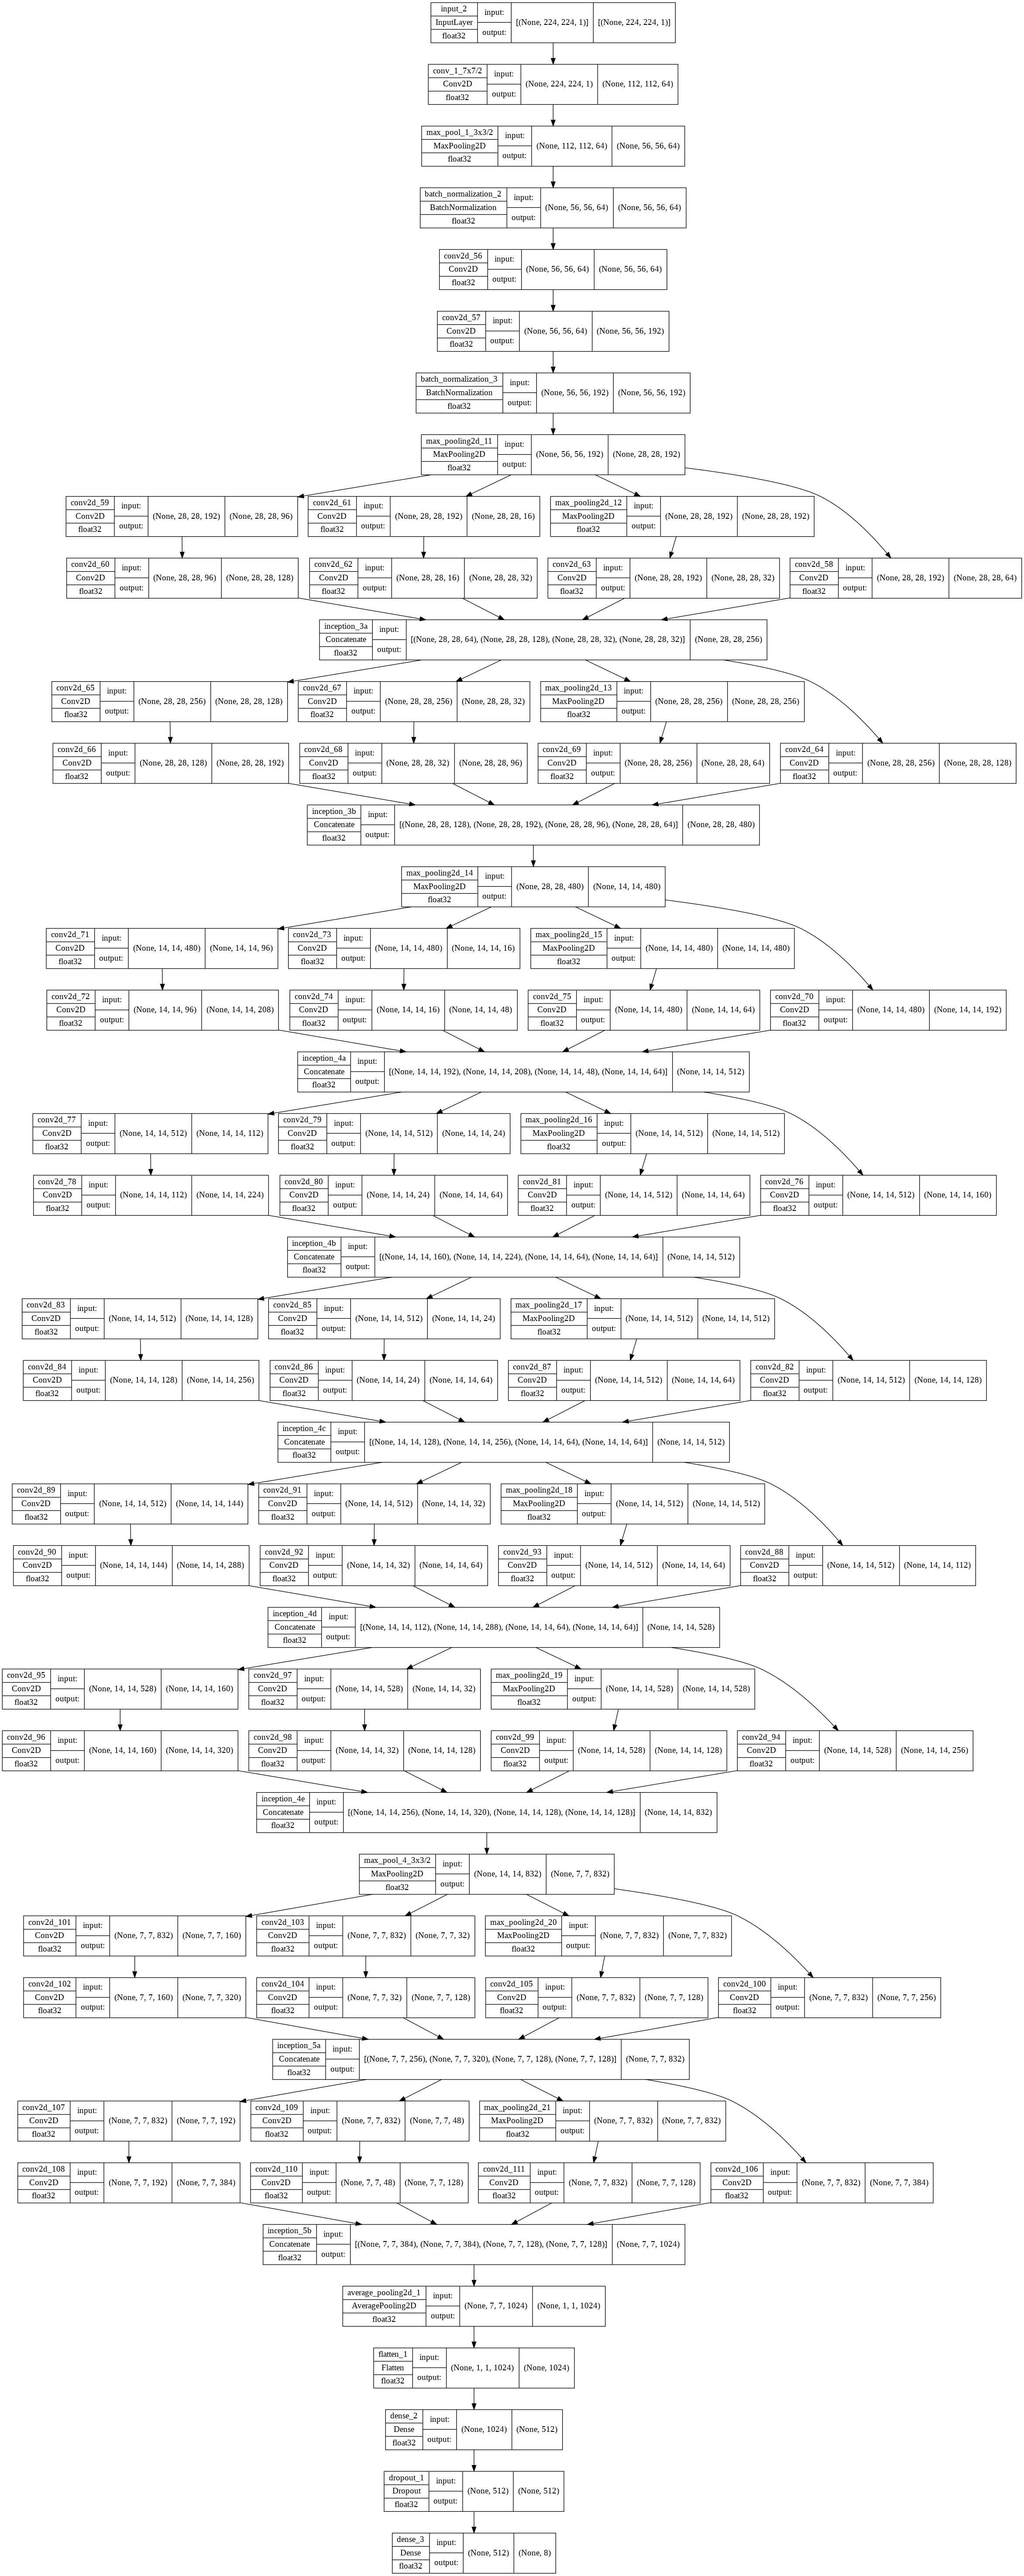

In [18]:
plot_model(model, to_file='baseline_conv.png', show_shapes=True, show_dtype=True, show_layer_names=True)

In [19]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(train_data_genarator, validation_data = val_data_genarator, epochs = 200, callbacks=[early_stop, check_pointer, reduce_lr])

Epoch 1/200
115/115 [==============================] - 225s 2s/step - loss: 2.0780 - accuracy: 0.1336 - val_loss: 2.0829 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/200
115/115 [==============================] - 195s 2s/step - loss: 2.0668 - accuracy: 0.1487 - val_loss: 2.0728 - val_accuracy: 0.1460 - lr: 0.0010
Epoch 3/200
115/115 [==============================] - 194s 2s/step - loss: 2.0507 - accuracy: 0.1699 - val_loss: 2.0576 - val_accuracy: 0.1645 - lr: 0.0010
Epoch 4/200
115/115 [==============================] - 195s 2s/step - loss: 1.9563 - accuracy: 0.2230 - val_loss: 1.9846 - val_accuracy: 0.2013 - lr: 0.0010
Epoch 5/200
115/115 [==============================] - 194s 2s/step - loss: 1.7975 - accuracy: 0.2982 - val_loss: 1.7815 - val_accuracy: 0.2998 - lr: 0.0010
Epoch 6/200
115/115 [==============================] - 194s 2s/step - loss: 1.6904 - accuracy: 0.3413 - val_loss: 1.7657 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 7/200
115/115 [==============================] - 194

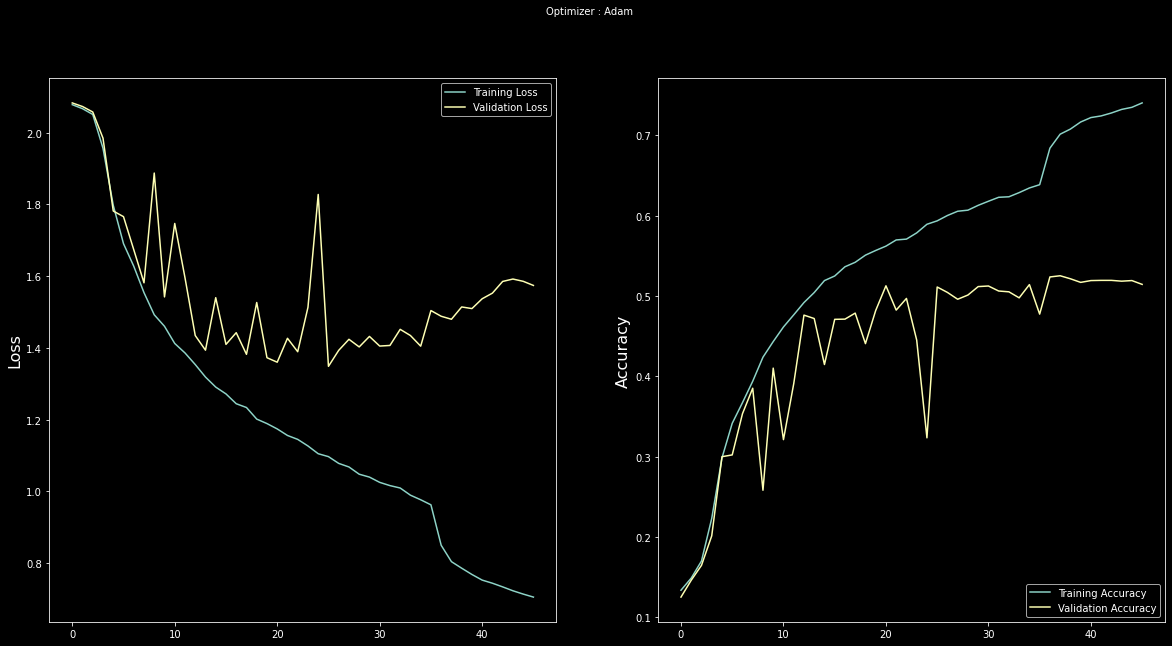

In [21]:
plt.style.use('dark_background')
plt.figure(figsize=(20,10)) 
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()